In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM,GRU,Dense,MaxPooling1D,Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import add,Conv1D
from tensorflow.keras.layers import Input,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)
from collections import Counter

# Ścieżka do katalogu z plikami audio
directory_path = 'C:/Users/u144572/self_development/final_model/audio_and_txt_files_test/'
# Pobierz listę plików w katalogu
filenames = [f for f in os.listdir(directory_path) if f.endswith('.wav')]
# print(filenames)

def extract_last_component(filename):
    base_name = os.path.splitext(filename)[0]
    components = base_name.split('_')
    return components[-1]

last_components = [extract_last_component(filename) for filename in filenames]
component_counts = Counter(last_components)

for component, count in component_counts.items():
    print(f"{component}: {count}")

import pandas as pd

df = pd.DataFrame(component_counts.items(), columns=['Component', 'Count'])
print(df)

i_list = []
rec_annotations = []
rec_annotations_dict = {}
root = 'C:/Users/u144572/self_development/final_model/audio_and_txt_files_test/'

filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
recording_info.head()

my_index = pd.Series(list(rec_annotations_dict.keys()))

rec_annotations_dict
## Get Respiratory Cycle length and Diagnosis
res_rate_list = []
for i in range (92):
    cycle_df = pd.DataFrame( list(rec_annotations_dict.values())[i],columns=['Start', 'End' ,'cycle length'])
    cycle_df['cycle length'] = cycle_df['End']-cycle_df['Start']
    average = cycle_df[["Start","End","cycle length"]].mean(axis=0)
    df = pd.DataFrame(average).T
    res_rate_list.append(df)
res_rate_df = pd.concat(res_rate_list,ignore_index =True)
res_rate_df['filename']= my_index.values
res_rate_df['filename']= res_rate_df['filename'].str[:3]
res_rate_df.sort_values(by=['filename'])
# Respiratory cycle = Cycle length // 60 seconds 
avg = res_rate_df.groupby('filename').mean()
avg['respiratory_rate'] = 60 / avg['cycle length']

Meditron: 14
AKGC417L: 64
Litt3200: 4
LittC2SE: 10
  Component  Count
0  Meditron     14
1  AKGC417L     64
2  Litt3200      4
3  LittC2SE     10


C:\Users\u144572\AppData\Roaming\Python\Python39\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\u144572\AppData\Local\Temp\ipykernel_51344\453775005.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  respiratory_cycle_number = avg[avg.index == file_name[:3]]["respiratory_rate"][0]
C:\Users\u144572\AppData\Local\Temp\ipykernel_51344\453775005.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  respiratory_cycle

                      Metric     Value
0  Mean Absolute Error (MAE)  1.818745
1   Mean Squared Error (MSE)  7.771126
2                   R² Score  0.852196


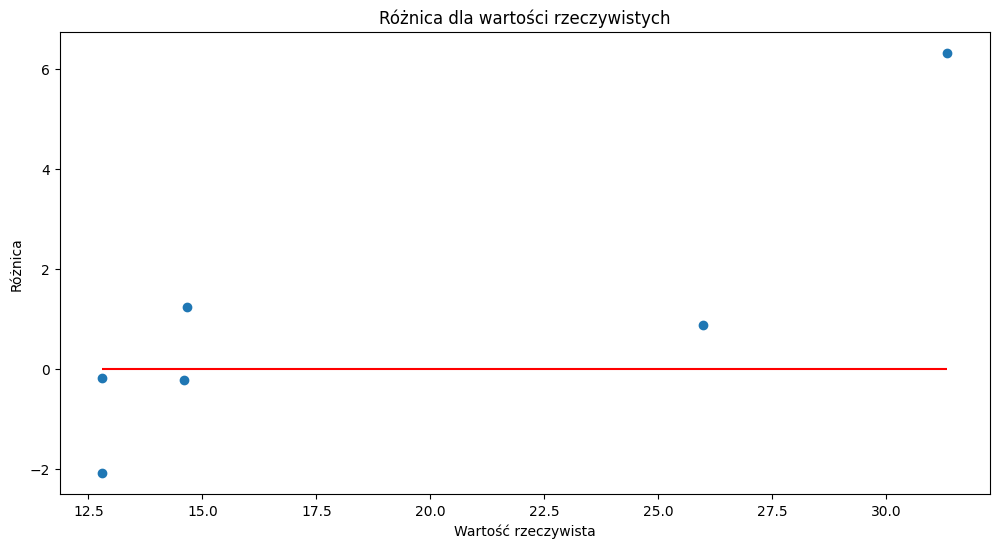

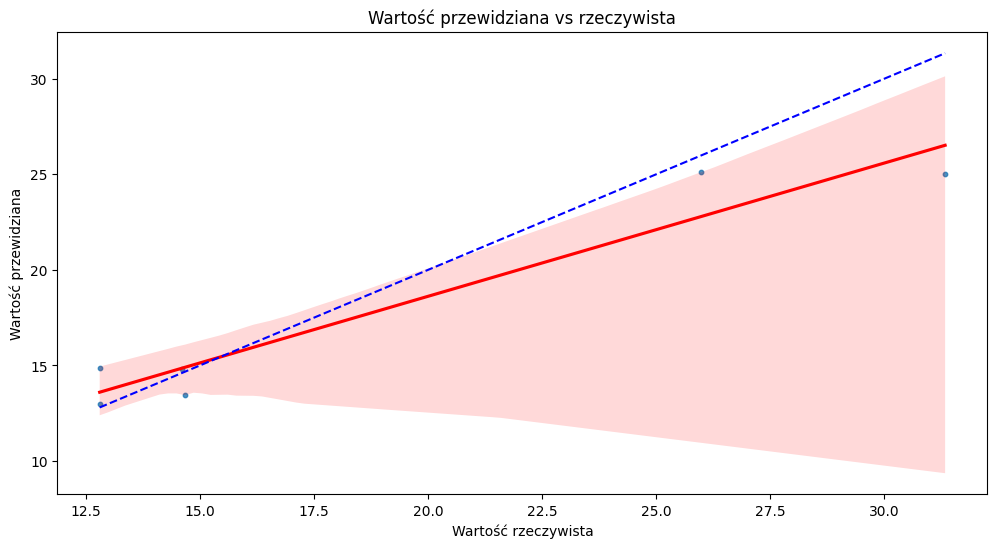

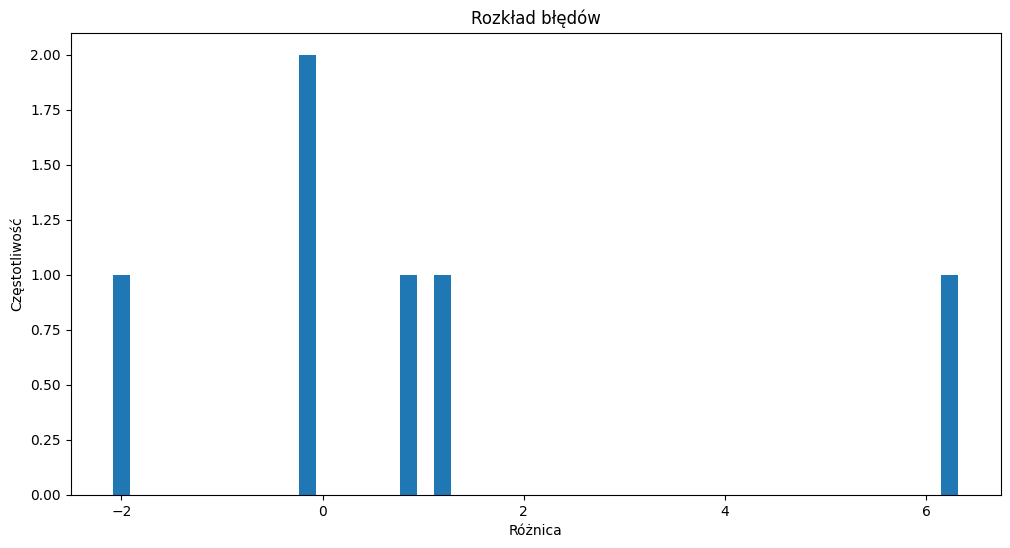

In [5]:
import re
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
root = '../audio_and_txt_files_test/'

filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.wav' in s]
filenames
# Load your model here
model = load_model('model_train_val.h5')
model.load_weights('model_train_val.weights.h5')

def calculated_rr_and_predicted(file_name, root):
    respiratory_cycle_number = avg[avg.index == file_name[:3]]["respiratory_rate"][0]
    rr = respiratory_cycle_number

    # Load audio with 22050 Hz sampling rate
    data_x, sampling_rate = librosa.load(f'{root}{file_name}.wav', res_type='kaiser_fast')

    if librosa.get_duration(y=data_x, sr=sampling_rate) < 21:
        return pd.DataFrame()
    
    # Extract features using MFCC (50 features)
    features = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=50).T, axis=0)

    # Reshape features to match the model's input shape (1, 50, 1)
    features = features.reshape(1, 50, 1)
    
    # Get the prediction
    predicted_value = model.predict(features, verbose=0)[0][0]

    return pd.DataFrame(data=[[file_name, rr, 
                            #    (predicted_value / (audio_length / 60))
                            predicted_value
                            ]], columns=['patient_id', 'rr', "rr_predicted"])

i_list = []
for s in filenames:
    i = calculated_rr_and_predicted(s, root)
    if not i.empty:
        i_list.append(i)
recording_info = pd.concat(i_list, axis=0)

# Calculate metrics
mae = mean_absolute_error(recording_info['rr'], recording_info['rr_predicted'])
mse = mean_squared_error(recording_info['rr'], recording_info['rr_predicted'])
r2 = r2_score(recording_info['rr'], recording_info['rr_predicted'])

metrics_df = pd.DataFrame({
    'Metric': ['Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)', 'R² Score'],
    'Value': [mae, mse, r2]
})


import os
if not os.path.isdir("plots_test_kaggle"):
    os.makedirs('plots_test_kaggle')

# Display the metrics
print(metrics_df)

# Plotting
def plot_results(df):
    # Calculate residuals
    residuals = df['rr'] - df['rr_predicted']
    
    # Residuals Plot
    plt.figure(figsize=(12, 6))
    plt.scatter(df['rr'], residuals)
    plt.hlines(y=0, xmin=min(df['rr']), xmax=max(df['rr']), colors='r')
    plt.title('Różnica dla wartości rzeczywistych')
    plt.xlabel('Wartość rzeczywista')
    plt.ylabel('Różnica')
    plt.savefig("plots_test_kaggle/roznia_dla_wartosci_rel")
    plt.show()

    # Predicted vs Actual Values with Linear Regression
    plt.figure(figsize=(12, 6))
    sns.regplot(x='rr', y='rr_predicted', data=df, scatter_kws={'s':10}, line_kws={"color": "red"})
    plt.plot([min(df['rr']), max(df['rr'])], [min(df['rr']), max(df['rr'])], color='blue', linestyle='dashed')  # Line of perfect prediction
    plt.title('Wartość przewidziana vs rzeczywista')
    plt.xlabel('Wartość rzeczywista')
    plt.ylabel('Wartość przewidziana')
    plt.savefig("plots_test_kaggle/pred_vs_rel")
    plt.show()

    # Error Distribution (Histogram of residuals)
    plt.figure(figsize=(12, 6))
    plt.hist(residuals, bins=50)
    plt.title('Rozkład błędów')
    plt.xlabel('Różnica')
    plt.ylabel('Częstotliwość')
    plt.savefig("plots_test_kaggle/rozklad_bledow")
    plt.show()

# Call the plotting function
plot_results(recording_info)